In [1]:
from IPython.display import display, HTML
hide_prompt_style = """
<style>
/* JupyterLab 기준, InputPrompt/OutputPrompt 클래스 숨기기 */
.lm-Widget.jp-InputPrompt.jp-InputArea-prompt,
.lm-Widget.jp-OutputPrompt.jp-OutputArea-prompt {
    display: none !important;
}
</style>
"""

display(HTML(hide_prompt_style))

## 머신러닝1 
- 한국에 위치한 A자동차 회사에서 해외로부터 부품을 수입해온다. 20년 1월부터 25년 3월까지의 수입이벤트가 발생한 순간의 데이터를 나타낸다.
- m1.csv
    - timestamp : 한국시각 
    - country : 수입국가 (4개국, europe,india,japan,usa)
    - part_cateogry: 부품 카테고리
    - unit_price : 부품 가격 (수입국가의 화폐 단위에 맞춰짐)
    - quantity : 부품수량
    - part_ID : 부품 카테고리 세부 부품명
    - 참고
        - 같은 부품이라도 시간에 따라 가격이 달라질 수 있다.

- m1_exchange.csv
    - 20년 4월부터 25년 3월까지의 환율정보가 담겨있다. (각 국가의 기준단위에 대한 krw(원) 가격)
    - type : 국가 정보 (jpy 1엔, usd 1달러, eur 1유로, inr 1루피)   

In [3]:
import pandas as pd

df =pd.read_csv('m1.csv')
exc =pd.read_csv('m1_exchange.csv')

머신러닝1     
아래의 기준으로 전처리를 시행하라    
1. 각 부품의 발주건에 대한 총수입금액 컬럼(total_price)을 만들고 계산하려한다..   
    a. 국가별 관세 비율은 다음과 같다. 미국(25%), 인도(5%), 유럽(10%), 일본(3%)     
    b. 일자별 환율은 공휴일 및 주말은 발표되지 않는다.     
    c. 공휴일 및 주말에 구매한 건(환율 데이터에 날짜가 없는 경우)에 대한 환율 계산은 13:00 이전에는 전날의 환율을, 13:00 이후에는 다음날의 환율을 적용한다.    
       (연속으로 쉬는 경우에도 그 다음 영업일의 환율을 반영)      
    d. A자동차사의 각 부품에 대한 총 수입금액은 unit_price * quantity * (1+ 관세/100) * 일자별 환율과 같다.   

In [9]:
display(df.sample(2))
display(exc.sample(2))

,timestamp,country,part_category,unit_price,quantity,part_ID
12623,2022-08-23 11:23:00,India,Brake,9941.57,32,IDS_1969
21353,2024-09-30 02:33:00,Japan,Brake,28559.33,22,IDS_4124


,일자,기준환율,type
274,2024.02.27,1331.40,usd-krw
4832,2020.09.10,16.23,inr-krw


In [13]:
exc['일자'] = pd.to_datetime(exc['일자']) # 2020년 3월부터 존재하기 때문

In [18]:
# 1. 두가지 컬럼 생성 -> 휴일여부(= 환율일자가 존재하지 않는 구매날짜들), 13:00기준 이전,이후 구매여부
# 2. apply 이용해서 조건마다 해당하는 계산을 진행

df['date'] = pd.to_datetime(df['timestamp']).dt.date # object 형식으로 저장이 된다.
df['date'] = pd.to_datetime(pd.to_datetime(df['timestamp']).dt.date) # datetime64 형식으로 저장이 된다.
df['date'] = pd.to_datetime(df['timestamp'].str.split(' ').str[0]) # datetime64 형식으로 저장이 된다.

In [65]:
# 환율의 값이 존재하는 최소값 이상의 일자 데이터만 필터하고 시작
df_filter = df[df['date'] >= exc['일자'].min()].reset_index(drop=True).copy()

In [131]:
# 휴일여부
df_filter['is_holiday'] = df_filter['date'].map(lambda x : 0 if x in exc['일자'].values else 1)
df_filter['is_holiday'].value_counts()

# 시간을 추출하는 2가지방법
# pd.to_datetime(df_filter['timestamp']).dt.hour
# df_filter['timestamp'].str.split(' ').str[1].str.split(':').str[0].astype('int')

# 13:00 이전,이후 구분
df_filter['is_over_time'] = pd.to_datetime(df_filter['timestamp']).dt.hour.map(lambda x : 1 if x>=13 else 0 )


# apply 이용해서 조건마다 해당하는 계산을 진행
# df_filter['date'].dt.weekday.value_counts().sort_index() # 0: 월요일, 6 : 토요일
# 잘 정의된 def 만들고 파라미터로 country, date, is_holiday, is_over_time

def check_change_day(x):
    
    # axis=1 옵션을 apply에 적용하면 행 별로 사용할 수 있다.
    country = x['country'] # x.values[0]
    date    = x['date'] # type
    is_holiday = x['is_holiday']
    is_over_time= x['is_over_time']

    country_mapper = {
        'Japan' : 'jpy-krw',
        'India' : 'inr-krw',
        'Europe': 'eur-krw',
        'USA'   : 'usd-krw'
    }

    target_chage = country_mapper[country]
    exchage_value = ''
    
    if is_holiday == 0:
        exchage_value = exc[(exc['type'] ==target_chage) & (exc['일자'] == date)]['기준환율'].values
        
    else:
        if is_over_time ==1:
            # 최초의 date는 exc['일자'] 존재하지 않음
            # +1 day를 반복적으로 하면서 exc['일자'] 존재하는 순간 멈춘다.

            for day in range(1,7):
                target_day = date + pd.Timedelta(days=day)
                if target_day in exc['일자'].values:
                    exchage_value = exc[(exc['type'] ==target_chage) & (exc['일자'] == target_day)]['기준환율'].values
                    break

        else:
            for day in range(1,7):
                target_day = date - pd.Timedelta(days=day)
                if target_day in exc['일자'].values:
                    exchage_value = exc[(exc['type'] ==target_chage) & (exc['일자'] == target_day)]['기준환율'].values
                    break

    # 그날 곱해야하는 환율 금액
    return exchage_value[0]



df_filter['exv'] = df_filter[['country', 'date', 'is_holiday', 'is_over_time']].apply(check_change_day,axis=1)

In [134]:
df_filter['country'].unique()

array(['Japan', 'India', 'Europe', 'USA'], dtype=object)

In [135]:
# 최종 값 추출
# A자동차사의 각 부품에 대한 총 수입금액은 unit_price * quantity * (1+ 관세/100) * 일자별 환율과 같다.
#  미국(25%), 인도(5%), 유럽(10%), 일본(3%)
def cal_price(x):
    c = x['country']
    up = x['unit_price']
    q = x['quantity']
    ex = x['exv']

    c_ratio ={
        'Japan':3,
        'India':5,
        'Europe':10,
        'USA': 25
    }
    return up * q * (1 + c_ratio[c] /100) * ex

df_filter['total_price'] =  df_filter[['country','unit_price','quantity','exv']].apply(cal_price,axis=1)

In [150]:
df_filter['total_price_'] = df_filter['total_price'] // 1000000 # 백만원 단위로 출력
df_filter['total_price_'].head()

0    18.0
1     6.0
2     2.0
3     7.0
4     3.0
Name: total_price_, dtype: float64

In [ ]:
# 다른분 풀이
'''
저는 환율 데이터를 날짜를 date_range로 모두 채워 넣고,     
결측치를 13시이전, bfill, 13시 이후 ffill 로 결측치 처리하고 (4개 국가 별로)    
총 8개 데이터 만들어서 합친 다음 df와 merge 했습니다. 이 방법은 안되나요?
'''

In [172]:
w = df_filter[(df_filter.is_holiday ==1 )][['timestamp','total_price','is_holiday','is_over_time']]
w['total_price'] = w['total_price'].astype('int')
w.sample(2)

,timestamp,total_price,is_holiday,is_over_time
20527,2025-01-04 06:14:00,8522815,1,0
17128,2024-02-10 19:26:00,3327586,1,1


머신러닝2    
EDA를 시행하라. 시각화 포함

<Axes: xlabel='date'>

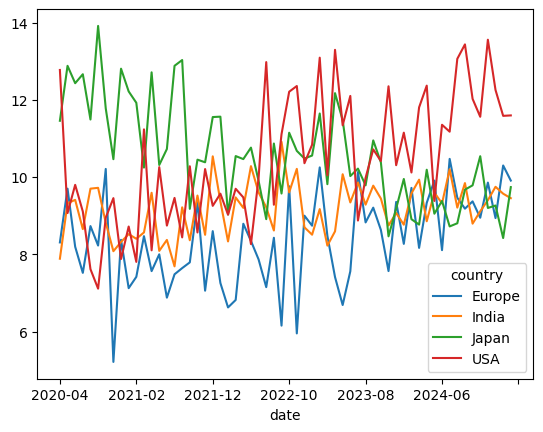

In [184]:
# 국가별 월별 수입금액

import matplotlib.pyplot as plt
import seaborn as sns

gg = df_filter.groupby([df_filter['date'].dt.strftime('%Y-%m'),'country'])['total_price_'].mean()
# gg.unstack() # groupy된 데이터프레임을 pivot / 
gg.unstack().plot()

<Axes: xlabel='date'>

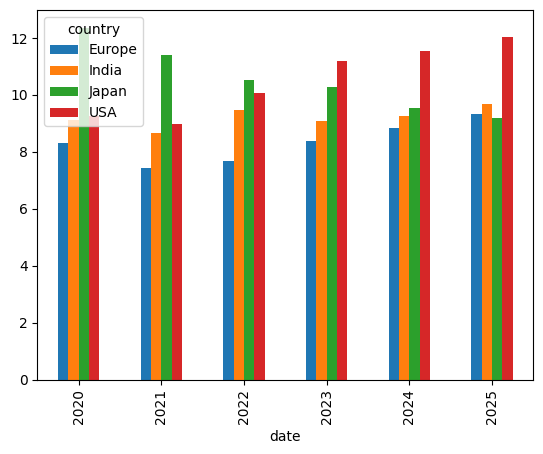

In [186]:
year_group = df_filter.groupby([df_filter['date'].dt.year,'country'])['total_price_'].mean()
# gg.unstack() # groupy된 데이터프레임을 pivot / 
year_group.unstack().plot(kind='bar')

# usa는 수입금액 증가 / japan 줄어듦

머신러닝3    
일자별 3국(미국,유럽,인도)수입컬럼 금액 및 파생변수를 통해 일본에서 수입한 금액을 예측하는 모델링을 진행하려한다.       
아래 기준으로 데이터를 분할하고 모델링을 진행하라.    

1. 데이터 전처리
    (파생변수생성)
    - 일자별 발주건들에 대해 국가별 주문수, 카테고리별 종류 수, 카테고리별 제품 수
    - 종속변수 : 일본의 수입금액 (독립변수가 존재하지 않는 일자는 제거)
    - 시간 관련 파생변수 4개
2. 모델링
    - 3가지 회귀모델
    - 평가지표 rmse
3. 데이터 분할
    - 일자 기준으로 정렬 후 행의 index기준으로(0부터시작) 3의 배수이거나 4의 배수이거나 5의 배수라면 train 그 외의 경우 test로 진행

In [ ]:
# 컬럼 (일자, 발주건들에 대해 국가별 주문수, 카테고리별 종류 수, 카테고리별 제품 수)

In [215]:
remove_jp = df_filter[df_filter.country != 'Japan'].reset_index(drop=True)
df1 = remove_jp.groupby(['date','country']).size().unstack().fillna(0).astype('int') # 일자,국가별 발주 횟수
df2 = remove_jp.groupby(['date','part_category']).size().unstack().fillna(0).astype('int')
df3 = remove_jp.groupby(['date','part_category'])['quantity'].sum().unstack().fillna(0).astype('int')

t = pd.concat([df1,df2,df3],axis=1)

In [243]:
y = df_filter[df_filter.country == 'Japan'][['date','total_price']].groupby(['date'])['total_price'].sum()
tt = pd.concat([t,y],axis=1).dropna().reset_index() # 결측치제거
tt['month'] = tt['date'].dt.month
tt['year'] = tt['date'].dt.year
tt['day'] = tt['date'].dt.day
tt['quarter'] = tt['date'].dt.quarter

train = tt.iloc[[x for x in tt.index if (x % 3 ==0) or (x % 4 ==0) or( x % 5 ==0)]]
test = tt[~tt.index.isin(train.index)]

In [244]:
train.shape , test.shape

((792, 19), (527, 19))

질문      
EDA는 본인이 중요하다고 생각하는 주제를 잡아서 풀면 되나요?      
아니면 출제자가 수험자에게 바라는 분석 그래프가 따로 있을까요?(점수 가감점 등)

## 통계1
- 주택 가격 데이터이다. (종속변수 price)
- 3차 다항회귀 모델을 학습하고 평가하라.
- 독립변수간의 상호작용 항만을 고려한 경우와 그렇지 않은 경우의 r2값을 포함한 모델 결과 해석을 진행하라.

In [245]:
df =pd.read_csv('./s1.csv')
df.head()

,Size,Rooms,Year_Built,Distance_to_Park,Price
0,87.454012,5,2004.5,2.13,1158.64
1,145.071431,4,1982.7,4.33,1084.19
2,123.199394,3,1981.6,4.62,943.60
3,109.865848,4,1985.8,2.38,1185.59
4,65.601864,5,1980.6,2.46,1061.23


In [253]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = df.drop(columns =['Price'])
y = df['Price']

poly = PolynomialFeatures(degree=3,) # 몇차항으로 만들건지에 대한 옵션
x_poly = poly.fit_transform(x)

model = LinearRegression()
model.fit(x_poly,y)

# predict = ~~~

(300, 35)

In [252]:
poly.get_feature_names_out()

array(['1', 'Size', 'Rooms', 'Year_Built', 'Distance_to_Park', 'Size^2',
       'Size Rooms', 'Size Year_Built', 'Size Distance_to_Park',
       'Rooms^2', 'Rooms Year_Built', 'Rooms Distance_to_Park',
       'Year_Built^2', 'Year_Built Distance_to_Park',
       'Distance_to_Park^2', 'Size^3', 'Size^2 Rooms',
       'Size^2 Year_Built', 'Size^2 Distance_to_Park', 'Size Rooms^2',
       'Size Rooms Year_Built', 'Size Rooms Distance_to_Park',
       'Size Year_Built^2', 'Size Year_Built Distance_to_Park',
       'Size Distance_to_Park^2', 'Rooms^3', 'Rooms^2 Year_Built',
       'Rooms^2 Distance_to_Park', 'Rooms Year_Built^2',
       'Rooms Year_Built Distance_to_Park', 'Rooms Distance_to_Park^2',
       'Year_Built^3', 'Year_Built^2 Distance_to_Park',
       'Year_Built Distance_to_Park^2', 'Distance_to_Park^3'],
      dtype=object)

In [255]:
poly = PolynomialFeatures(degree=3,interaction_only=True) # 몇차항으로 만들건지에 대한 옵션
x_poly = poly.fit_transform(x)

In [256]:
poly.get_feature_names_out()

array(['1', 'Size', 'Rooms', 'Year_Built', 'Distance_to_Park',
       'Size Rooms', 'Size Year_Built', 'Size Distance_to_Park',
       'Rooms Year_Built', 'Rooms Distance_to_Park',
       'Year_Built Distance_to_Park', 'Size Rooms Year_Built',
       'Size Rooms Distance_to_Park', 'Size Year_Built Distance_to_Park',
       'Rooms Year_Built Distance_to_Park'], dtype=object)